In [1]:
# Analyse tournament results
import os 
import sys
import pandas as pd
import requests
import glob
import json
import ast
import matplotlib.pyplot as plt

# Build the path to the pdb files
file_dir = os.getcwd()
folder_name = file_dir.split('/')[-1]
repo_dir = file_dir.replace(f'/{folder_name}', '')
plot_dir = f'{file_dir}/plots'
os.makedirs(plot_dir, exist_ok=True)
pdb_dir = f"{repo_dir}/tournament_benchmark/gpcr_tournament"
interactions_with_decoys_df = pd.read_csv(f"{repo_dir}/classifier_benchmark_data/output/6_interactions_with_decoys.csv")
principal_agonists_df = interactions_with_decoys_df[interactions_with_decoys_df["Decoy Type"] == "Principal Agonist"]

sys.path.append(repo_dir)
from colors import COLOR

chosen_grn_path = f"{repo_dir}/grn_analysis/chosen_grns.txt"
with open(chosen_grn_path) as f:
    chosen_grns = f.readlines()
    chosen_grns = [x.strip() for x in chosen_grns]
    chosen_grns = [x.replace("x", ".") for x in chosen_grns]

# Get the pdb files - list all pdb files in the pdb_dir directory and its subdirectories
pdb_files = []
for root, dirs, files in os.walk(pdb_dir):
    for file in files:
        if file.endswith(".pdb"):
            pdb_files.append(os.path.join(root, file))

# Ranks of interest 
ranks = ["one_to_one", "one_to_two", "one_to_four", "one_to_eight", "one_to_ten"]

# Use glob to find all matching files
pattern = os.path.join(repo_dir, "tournament_benchmark/one_to_one/*/msas/chain_id_map.json")

matching_files = glob.glob(pattern)

# Print the list of matching files
for file_path in matching_files:

    # Read the chain_id_map.json file
    chain_id_map = json.load(open(file_path))
    receptor = chain_id_map["A"]["description"]
    principal_agonist = principal_agonists_df[principal_agonists_df["Target ID"] == receptor]["Decoy ID"].values[0]

    ligand_chain = "None"
    for key in chain_id_map:
        if str(chain_id_map[key]["description"]) == str(principal_agonist):
            ligand_chain = key
    
    # Set the column value in principal_agonists_df to the ligand chain
    principal_agonists_df.loc[principal_agonists_df["Target ID"] == receptor, "Ligand Chain"] = ligand_chain

principal_agonists_df


/var/folders/2w/tg0hs2fd7sn32fp3sjbd1s6h0000gn/T/ipykernel_4946/177091575.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  principal_agonists_df.loc[principal_agonists_df["Target ID"] == receptor, "Ligand Chain"] = ligand_chain


,Decoy Type,Decoy Rank,Original Target,Target Similarity to Original Target,Ligand Sequence,GPCR Sequence,Identifier,Target ID,Decoy ID,Acts as agonist,Ligand Chain
10,Principal Agonist,NaN,ackr1_human,100.0,SPYSSDTTPCCFAYIARPLPRAHIKEYFYTSGKCSNPAVVFVTRKN...,MGNCLHRAELSPSTENSSQLDFEDVWNSSYGVNDSFPDGDYGANLE...,ackr1_human___758,ackr1_human,758,True,B
21,Principal Agonist,NaN,ackr2_human,100.0,SPYSSDTTPCCFAYIARPLPRAHIKEYFYTSGKCSNPAVVFVTRKN...,MAATASPQPLATEDADSENSSFYYYDYLDEVAFMLCRKDAVVSFGK...,ackr2_human___758,ackr2_human,758,True,B
32,Principal Agonist,NaN,ackr3_human,100.0,KPVSLSYRCPCRFFESHVARANVKHLKILNTPNCALQIVARLKNNN...,MDLHLFDYSEPGNFSDISWPCNSSDCIVVDTVMCPNMPNKSVLLYT...,ackr3_human___4358,ackr3_human,4358,True,B
43,Principal Agonist,NaN,ackr4_human,100.0,GTNDAEDCCLSVTQKPIPGYIVRNFHYLLIKDGCRVPAVVFTTLRG...,MALEQNQSTDYYYEENEMNGTYDYSQYELICIKEDVREFAKVFLPV...,ackr4_human___810,ackr4_human,810,True,B
54,Principal Agonist,NaN,acthr_human,100.0,SYSMEHFRWGKPVGKKRRPVKVYPNGAEDESAEAFPLEF,MKHIINSYENINNTARNNSDCPRVVLPEEIFFTISIVGVLENLIVL...,acthr_human___3633,acthr_human,3633,True,B
...,...,...,...,...,...,...,...,...,...,...,...
1318,Principal Agonist,NaN,v1br_human,100.0,CYFQNCPRG,MDSGPLWDANPTPRGTLSAPNATTPWLGRDEELAKVEIGVLATVLV...,v1br_human___2168,v1br_human,2168,True,B
1329,Principal Agonist,NaN,v2r_human,100.0,CYFQNCPRG,MLMASTTSAVPGHPSLPSLPSNSSQERPLDTRDPLLARAELALLSI...,v2r_human___2168,v2r_human,2168,True,B
1340,Principal Agonist,NaN,vipr1_human,100.0,HSDAVFTDNYTRLRKQMAVKKYLNSILN,MRPPSPLPARWLCVLAGALAWALGPAGGQAARLQEECDYVQMIEVQ...,vipr1_human___1152,vipr1_human,1152,True,B
1351,Principal Agonist,NaN,vipr2_human,100.0,HSDAVFTDNYTRLRKQMAVKKYLNSILN,MRTLLPPALLTCWLLAPVNSIHPECRFHLEIQEEETKCAELLRSQT...,vipr2_human___1152,vipr2_human,1152,True,B


In [3]:
# Ranks of interest 
ranks = ["one_to_one", "one_to_two", "one_to_four", "one_to_eight", "one_to_ten"]

# Use glob to find all matching files
pattern = os.path.join(repo_dir, "tournament_benchmark/one_to_ten/*/msas/chain_id_map.json")
matching_files = glob.glob(pattern)
chain_map_dict = {}

# Print the list of matching files
for file_path in matching_files:

    # Model name
    model_name = file_path.split("/")[-3]
    receptor_name = model_name.split("one_to_")[0] + "human"

    # Get principal agonist from the dataframe
    receptor_df = interactions_with_decoys_df[interactions_with_decoys_df["Target ID"] == receptor_name]

    # Get principal agonist
    principal_agonist = receptor_df[receptor_df["Decoy Type"] == "Principal Agonist"]["Decoy ID"].values[0]

    # Read the chain_id_map.json file
    chain_id_map = json.load(open(file_path))
    chain_map_dict[model_name] = {}

    for key in chain_id_map:
        description = chain_id_map[key]["description"]
        # Save receptor and principal agonist chains to dictionary
        if "_human" in description:
            chain_map_dict[model_name]["Receptor"] = key
            continue
        elif description == str(principal_agonist):
            chain_map_dict[model_name]["Principal Agonist"] = key
            continue

        # Get decoy type
        decoy_type = receptor_df[receptor_df["Decoy ID"] == int(description)]["Decoy Type"].values[0]
        decoy_rank = str(int(receptor_df[receptor_df["Decoy ID"] == int(description)]["Decoy Rank"].values[0]))
        chain_map_dict[model_name][f"{decoy_type}{decoy_rank}"] = key

In [4]:
'''
Script to check whether a predicted receptor-ligand complex includes interactions between the ligand and the receptor.
The interactions will only focus on the generic residue numbers that are observed in the dataset of stucturally resolved complexes of 
GPCRs and endogenous peptide ligands or their non-endogenous analogues.
'''

import subprocess 
import os
from Bio.PDB.NeighborSearch import NeighborSearch
import pandas as pd
import glob
import csv 
import json

from Bio.PDB import PDBParser

def list_chain_ids(pdb_file):
    """
    Lists all chain IDs in a PDB file.
    
    Args:
    pdb_file (str): Path to the PDB file.
    
    Returns:
    list: A list of chain IDs found in the PDB file.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('pdb_structure', pdb_file)
    
    # Set to store unique chain IDs
    chain_ids = set()
    
    # Iterate through all models, chains, and residues to collect chain IDs
    for model in structure:
        for chain in model:
            chain_ids.add(chain.id)
    
    return sorted(list(chain_ids))


def get_chains_from_pdb(pdb_path, chain_to_get, output_path):
    """
    Helper function to get specific chains from a pdb file
    Note: requires pdb-tools to be installed using: pip install pdb-tools
    """
    chain_to_get = ",".join(chain_to_get)

    # Command to run on terminal - uses pdb-tools pdb_selchain to extract receptor and peptide chain from PDB file
    command = f"pdb_selchain -{chain_to_get} {pdb_path} > {output_path}"

    # Run command on terminal
    os.system(command)

    return output_path

def apply_generic_numbering(pdb_path, output_path, chain_to_get="B"):
    '''
    Function to apply generic numbering to a PDB file of a receptor. 
    '''
    # Apply generic numbering to the pdb file
    command = f'curl -X POST -F "pdb_file=@{pdb_path}" https://gpcrdb.org/services/structure/assign_generic_numbers'
    output = subprocess.check_output(command, shell=True)
    # Make sure output directory exists
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with open(output_path, 'wb') as f:
        f.write(output)

    # Compare lines in the input pdb and the output pdb 
    # and empty b-factor field in the output pdb so that only GRN
    # is stored in the b-factor field
    with open(pdb_path, 'r') as f:
        pdb = f.readlines()
        pdb = [line.strip() for line in pdb]
        pdb = [line for line in pdb if line.startswith("ATOM")]
        pdb = [line for line in pdb if line[21] == chain_to_get]
        
    with open(output_path, 'r') as f:
        output_pdb = f.readlines()
        output_pdb = [line.strip() for line in output_pdb]     
        output_pdb = [line for line in output_pdb if line.startswith("ATOM")] 
        output_pdb = [line for line in output_pdb if line[21] == chain_to_get]

    # Make a dictionary from residue number to generic residue number
    grn_dict = {}
    for i in range(len(pdb)):
        if pdb[i] != output_pdb[i]:
            residue_number = pdb[i][22:26].strip()
            generic_number = output_pdb[i][60:66].strip()
            grn_dict[residue_number] = generic_number
        else:
            # Replace the b-factor field with empty space
            output_pdb[i] = output_pdb[i][:60] + "     0" + output_pdb[i][66:]

    # Save the dictionary into a json file
    grn_json_path = output_path.replace(".pdb", ".json")
    with open(grn_json_path, 'w') as f:
        json.dump(grn_dict, f)

    # Save the pdb file with generic residue numbers
    with open(output_path, 'w') as f:
        for line in output_pdb:
            f.write(line + "\n")

    return output_path

def get_grn_positions(grn_pdb_path, receptor_chain):

    # Open grn_pdb file
    with open(grn_pdb_path, 'r') as f:
        grn_pdb = f.readlines()
        grn_pdb = [line.strip() for line in grn_pdb]

    # Get only CA atoms from the receptor chain
    ca_grn_pdb = [line for line in grn_pdb if "CA" == line[12:16].strip()]
    ca_grn_pdb = [line for line in ca_grn_pdb if line[21] == receptor_chain]

    # Make a dictionary with residue numbers as keys and generic residue numbers as values
    grn_dict = {}
    for grn_position in ca_grn_pdb:
        residue_number = grn_position[22:26].strip()
        generic_number = grn_position[60:66].strip()
        grn_dict[residue_number] = generic_number

    return grn_dict

def get_atom_list(pdb_path, grn_folder, pdb_name = None, receptor_chain = "B", ligand_chain = "C", search_radius = 6.6):

    # Open pdb using biopython
    from Bio.PDB import PDBParser
    parser = PDBParser()
    if pdb_name is None:
        pdb_name = pdb_path.split("/")[-1].split(".")[0]
        receptor_name = pdb_name.split("___")[0]
    else:
        receptor_name = pdb_name
    structure = parser.get_structure(pdb_name, pdb_path)

    # Save atom objects into two lists: one for the receptor and one for the peptide
    atom_list_receptor = []
    atom_list_peptide = []
    for atom in structure.get_atoms():
        chain_id = atom.get_full_id()[2]
        if chain_id == receptor_chain:
            atom_list_receptor.append(atom)
        elif chain_id == ligand_chain:
            atom_list_peptide.append(atom)

    # Apply generic numbering to the receptor
    grn_path = os.path.join(grn_folder, receptor_name + "_grn.pdb")
    grn_json_path = grn_path.replace(".pdb", ".json")
    if not os.path.exists(grn_path):
        apply_generic_numbering(pdb_path, grn_path)

    # Load the generic residue numbers from the json file
    with open(grn_json_path, 'r') as f:
        generic_residue_numbers = json.load(f)
     
    # Filter receptor atom list based on generic residue numbers
    grn_list_receptor = []
    for atom in atom_list_receptor:
        # Get residue number of atom
        residue_number = str(atom.get_parent().get_id()[1])
        if residue_number in generic_residue_numbers:
            grn_list_receptor.append(atom)

    # Concatenate two lists
    grn_list_receptor.extend(atom_list_peptide)

    # Get interactions between receptor and peptide
    ns = NeighborSearch(grn_list_receptor)
    all_neighbors = ns.search_all(search_radius, "R")
    all_neighbors = [pair for pair in all_neighbors if pair[0].get_full_id()[2] != pair[1].get_full_id()[2]]
    all_neighbors = sorted(all_neighbors, key=lambda x: x[0].get_full_id())
    
    # Return generic residue numbers for interacting receptor positions
    grns = []
    for pair in all_neighbors:
        res_n = pair[0].get_full_id()[-1][1]
        grns.append(generic_residue_numbers[str(res_n)])
    grns = list(set(grns))
    return sorted(grns)
    
# Path to the folder that contains the generic residue numbers for each receptor
grn_folder = f"{repo_dir}/tournament_benchmark/grn_pdbs"

# List all pdbs in pdb_directory and its subdirectories
pdb_directory = f"{repo_dir}/tournament_benchmark"
output_csv = f"{repo_dir}/tournament_benchmark/interacting_grns.csv"

# Process each PDB file and write results to the CSV file line by line
with open(output_csv, "w", newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["setup","pdb", "chain", "interacting_grns"])  # Write header
    for rank in ranks:
        c = 0
        pdb_files = glob.glob(f"{pdb_directory}/{rank}/*/*.pdb")
        print(f"Rank {rank}", flush = True)
        print(f"Number of pdb files: {len(pdb_files)}", flush = True)

        for pdb in pdb_files:

            chain_ids = list_chain_ids(pdb)
            chain_ids = sorted(chain_ids)
            chain_ids = chain_ids[1:]
            c += 1
            if os.path.exists(pdb):
                print(f"Processing {pdb}, {c}/{len(pdb_files)}", flush = True)
                for chain in chain_ids:
                    pdb_name = os.path.basename(pdb).split("_")[0]
                    grns = get_atom_list(pdb, grn_folder, pdb_name = pdb_name, ligand_chain = chain) 
                    pdb_name = os.path.basename(pdb).split(".")[0]
                    csv_writer.writerow([rank, pdb_name, chain, grns])

interactions_df = pd.read_csv(f"{repo_dir}/tournament_benchmark/interacting_grns.csv")

Rank one_to_one
Number of pdb files: 124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/one_to_one/vipr1_one_to_one/vipr1_one_to_one.pdb, 1/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/one_to_one/crfr1_one_to_one/crfr1_one_to_one.pdb, 2/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/one_to_one/agtr1_one_to_one/agtr1_one_to_one.pdb, 3/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/one_to_one/ssr5_one_to_one/ssr5_one_to_one.pdb, 4/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/one_to_one/galr2_one_to_one/galr2_one_to_one.pdb, 5/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/one_to_one/fpr3_one_to_one/fpr3_one_to_one.pdb, 6/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_pept

In [13]:
interactions_df = pd.read_csv(f"{repo_dir}/tournament_benchmark/interacting_grns.csv")
# Loop over interactions_df and keep only those rows that have at least 
# one generic residue number that is in chosen_grns
chosen_interactions = []
for index, row in interactions_df.iterrows():

    # Convert string back to list
    interacting_grns = ast.literal_eval(row["interacting_grns"])

    # Check if any of the interacting grns are in chosen_grns,
    # if so, keep the row, otherwise discard it
    c = 0
    results = list(row)
    interacting_pocket_grns = []
    for grn in interacting_grns:
        if grn in chosen_grns:
            interacting_pocket_grns.append(grn)
            c +=1

    results.append(interacting_pocket_grns)
    results.append(c)
    chosen_interactions.append(results)
chosen_interactions = pd.DataFrame(chosen_interactions, columns=["setup", "pdb", "chain", "interacting_grns", "interacting_pocket_grns", "num_interactions"])

# Sort the data frame first based on pdb, then by num_interactions descending
chosen_interactions = chosen_interactions.sort_values(by=["pdb", "num_interactions"], ascending=[True, False])
failed_interactions = chosen_interactions[chosen_interactions["num_interactions"] == 0]
failed_interactions = failed_interactions[failed_interactions["setup"] == "one_to_one"]
print(f"Number of failed interactions: {len(failed_interactions)}")
print(failed_interactions["pdb"])
chosen_interactions = chosen_interactions[chosen_interactions["num_interactions"] > 0]
chosen_interactions = chosen_interactions.groupby("pdb").first().reset_index()

# Replace anything after the first underscore with an empty string
chosen_interactions["protein"] = chosen_interactions["pdb"].str.replace(r"_.*", "_human", regex = True)

# Check which receptors have been structurally studied 
url = "https://gpcrdb.org/services/structure/"
response = requests.get(url)
data = response.json()
data = pd.DataFrame(data)

# Find out which "protein" entries in chosen_interactions are in data
chosen_interactions["structurally_studied"] = chosen_interactions["protein"].isin(data["protein"])
chosen_interactions[chosen_interactions["chain"] == "C"]["structurally_studied"].value_counts() 

Number of failed interactions: 15
22      fpr1_one_to_one
34      fshr_one_to_one
15      fzd1_one_to_one
101     fzd2_one_to_one
38      fzd6_one_to_one
10     g37l1_one_to_one
11     gp107_one_to_one
33     gpr37_one_to_one
86     gpr39_one_to_one
65     gpr75_one_to_one
108     hrh4_one_to_one
59      lgr4_one_to_one
14      lgr5_one_to_one
100     lgr6_one_to_one
122     par4_one_to_one
Name: pdb, dtype: object


structurally_studied
True     274
False    141
Name: count, dtype: int64

In [15]:
# Print value counts of chains
plot_percentages = {}
for rank in ranks:
    plot_data = chosen_interactions[chosen_interactions["setup"] == rank]["chain"].value_counts()
    plot_data = plot_data.reset_index()
    plot_data.columns = ["Chain", "Count"]
    plot_data["Percentage"] = plot_data["Count"] / 124 * 100
    plot_percentages[rank] = plot_data[plot_data["Chain"] == "C"]["Percentage"].values[0]

# Make dict to df
plot_data = pd.DataFrame(plot_percentages.items(), columns=["Setup", "Percentage"])
plot_data

,Setup,Percentage
0,one_to_one,87.903226
1,one_to_two,73.387097
2,one_to_four,62.903226
3,one_to_eight,54.032258
4,one_to_ten,56.451613


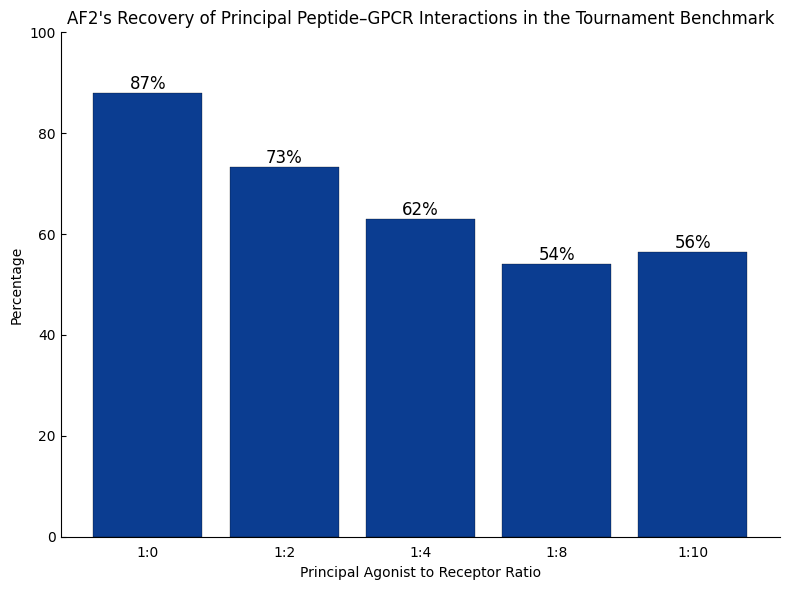

In [29]:
plot_data["Setup"] = plot_data["Setup"].replace("one_to_one", "1:0")
plot_data["Setup"] = plot_data["Setup"].replace("one_to_two", "1:2")
plot_data["Setup"] = plot_data["Setup"].replace("one_to_four", "1:4")
plot_data["Setup"] = plot_data["Setup"].replace("one_to_eight", "1:8")
plot_data["Setup"] = plot_data["Setup"].replace("one_to_ten", "1:10")

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(plot_data['Setup'], plot_data['Percentage'], color = COLOR["Receptor"], edgecolor='black', linewidth=0.2)

# Adding text labels to bars with counts higher than 10
for bar in bars:
    height = bar.get_height()
    if height > 10 and height < 100:
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}%', ha='center', va='bottom', fontsize=12, color='black')

plt.title("AF2's Recovery of Principal Peptide–GPCR Interactions in the Tournament Benchmark")
plt.xlabel('Principal Agonist to Receptor Ratio')
plt.ylabel('Percentage')
plt.ylim(0, 100)
#plt.grid(axis='y', linestyle='-', alpha=0.5)

# Make ticks go inward
plt.tick_params(axis='y', direction='in')

# Hide x tick marks
plt.tick_params(axis='x', which='both', bottom=False, top=False)

plt.tight_layout()

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.rcParams['svg.fonttype'] = 'none'
# Show the plot
plt.savefig(f"{plot_dir}/interactions_recovery_by_rank.svg")

In [23]:
# Get structurally studied receptors
structurally_studied_receptors = chosen_interactions[chosen_interactions["structurally_studied"] == True]

chosen_interactions[chosen_interactions["protein"] == "nmur1_human"]

,pdb,setup,chain,interacting_grns,interacting_pocket_grns,num_interactions,protein,structurally_studied
332,nmur1_one_to_eight,one_to_eight,C,"['1.28', '1.29', '1.30', '1.31', '1.35', '1.39...","[3.32, 4.61, 45.51, 45.52, 6.55, 7.34, 7.38]",7,nmur1_human,True
333,nmur1_one_to_four,one_to_four,C,"['1.28', '1.29', '1.30', '1.31', '1.35', '1.39...","[3.32, 4.61, 45.51, 45.52, 6.55, 7.34, 7.38]",7,nmur1_human,True
334,nmur1_one_to_one,one_to_one,C,"['1.28', '1.29', '1.30', '1.31', '1.35', '1.39...","[3.32, 4.61, 45.51, 45.52, 6.55, 7.34, 7.38]",7,nmur1_human,True
335,nmur1_one_to_ten,one_to_ten,C,"['1.28', '1.29', '1.30', '1.31', '1.35', '1.39...","[3.32, 4.61, 45.51, 45.52, 6.55, 7.34, 7.38]",7,nmur1_human,True
336,nmur1_one_to_two,one_to_two,C,"['1.28', '1.29', '1.30', '1.31', '1.35', '1.39...","[3.32, 4.61, 45.51, 45.52, 6.55, 7.34, 7.38]",7,nmur1_human,True


In [26]:
def hex_to_rgb(hex_code):
    """
    Convert a hex color code to an RGB tuple.
    """
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) / 255.0 for i in (0, 2, 4))

def generate_pymol_color_command(hex_code, color_name):
    """
    Generate a PyMOL set_color command string.
    """
    rgb = hex_to_rgb(hex_code)
    return f"set_color {color_name}, [{rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f}]"

def tournament_pymol(config_path, repo_dir, pdb_path, colors, chain_map):
    """
    Create a pymol script to visualize predicted vs experimental structures for a given PDB file
    """

    pdb = pdb_path.split("/")[-1].split(".")[0]
    pdb = pdb.split("_")[0]
    object_name = pdb + "_tournament"

    # Shift chain map ids by one letter ahead
    chain_map = {key: chr(ord(value) + 1) for key, value in chain_map.items()}

    # Read lines from the config file
    with open(config_path, 'r') as f:
        config_file = f.readlines()

    # Write the pymol script and define custom colors
    script = "".join(config_file)
    script += f"\n\n\n"

    script += generate_pymol_color_command(colors["Principal Agonist"], f"PrincipalAgonist") + "\n"
    for i in range(5):
        script += generate_pymol_color_command(colors[f"Similar{i}"], f"Similar{i}") + "\n"
        script += generate_pymol_color_command(colors[f"Dissimilar{i}"], f"Dissimilar{i}") + "\n"
    
    script += f"\n\n\n"

    # Load model
    script += f"load {pdb_path}, {object_name}\n"

    # Color receptor
    script += f"color white, {object_name} and chain {chain_map['Receptor']}\n"

    # Color AlphaFold structures
    script += f"color PrincipalAgonist, {object_name} and chain {chain_map['Principal Agonist']}\n"
    for i in range(5):
        script += f"color Similar{i}, {object_name} and chain {chain_map[f'Similar{i}']}\n"
        script += f"color Dissimilar{i}, {object_name} and chain {chain_map[f'Dissimilar{i}']}\n"
   
    # Finetune the visualization
    script += "\n\n\n"
    script += f"set cartoon_transparency, 0.25, chain {chain_map['Receptor']}\n"
    script += "hide (hydro)\n"
    script += "hide everything, not polymer\n"
    for chain in ["C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M"]:
        script += f"hide everything, chain {chain}\n"
        script += f"set cartoon_transparency, 0, chain {chain}\n"
        script += f"set cartoon_transparency, 0, chain {chain}\n"
    script += f"set cartoon_loop_radius, 0.4\n\n\n"

    # Separate ligand into its own object
    for chain in chain_map.keys():
        chain_cleaned = chain.replace(" ", "_")
        script += f"create {chain_cleaned}, {object_name} and chain {chain_map[chain]}\n"
        script += f"show cartoon, {chain_cleaned}\n"

        # Set loop width
        loop_radius = 0.7
        script += f"set cartoon_oval_width, {loop_radius}, {chain_cleaned}\n"
        script += f"set cartoon_loop_radius, {loop_radius}, {chain_cleaned}\n"
    script += f"zoom\n"

    # Save script
    output_dir = f"{repo_dir}/tournament_benchmark/pymol_scripts/"
    os.makedirs(output_dir, exist_ok=True)
    script_path = f"{output_dir}/{object_name}.pml"    
    with open(script_path, 'w') as f:
        f.write(script)

# Test the function
pdb = f"{repo_dir}/tournament_benchmark/one_to_ten/nmur1_one_to_ten/nmur1_one_to_ten.pdb"
config_path = f"{repo_dir}/structure_benchmark_data/pymol_scripts/pymol_config.txt"
chain_map = chain_map_dict[pdb.split("/")[-2]]

print(chain_map)

tournament_pymol(config_path, repo_dir, pdb, COLOR, chain_map)

{'Receptor': 'A', 'Principal Agonist': 'B', 'Similar3': 'C', 'Similar4': 'D', 'Similar0': 'E', 'Similar1': 'F', 'Similar2': 'G', 'Dissimilar0': 'H', 'Dissimilar1': 'I', 'Dissimilar2': 'J', 'Dissimilar3': 'K', 'Dissimilar4': 'L'}
